In [1]:
cd

C:\Users\workspace


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import sklearn
import imageio

In [4]:
import imgaug.augmenters as iaa
import imgaug as ia
import math

In [5]:
print(tf.__version__)

2.8.0


In [6]:
data_path = './workspace1/data/ucf101_top5/'

In [7]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [8]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path+"test.csv")

In [9]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]
test_df["label"] = test_df["tag"]

In [10]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [11]:
for index, data in enumerate(test_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    test_df["label"].replace(data, index, inplace=True) 

In [12]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)
test_df=sklearn.utils.shuffle(test_df)

In [13]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [14]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)

In [15]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [16]:
# 비디오 프레임을 이미지로 변환한 데이터를 X_train에 저장
# 비디오 프레임 이미지의 종류를 y_train에 저장
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"] , data_path + "test/")

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [18]:
#Resnet
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import VGG16, VGG19

In [20]:
vggnet16 = VGG16(include_top = False, input_shape = (224, 224, 3))
vggnet19 = VGG19(include_top = False, input_shape = (224, 224, 3))
resnet50 = ResNet50V2(include_top = False, input_shape = (224, 224, 3))
resnet101 = ResNet101V2(include_top = False, input_shape = (224, 224, 3))
resnet152 = ResNet152V2(include_top = False, input_shape = (224, 224, 3))

In [21]:
vggnet16.trainable=False
vggnet19.trainable=False
resnet50.trainable=False
resnet101.trainable=False
resnet152.trainable=False

In [22]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

C:\Users\workspace\anaconda3\envs\workspace1\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
C:\Users\workspace\anaconda3\envs\workspace1\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [23]:
# 이미지를 증강시켜서 배치 사이즈 만큼씩 리턴하는 클래스 구현

class  ImageSequence(tf.keras.utils.Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # image_arr : 이미지가 저장된 배열
    # label_arr : 이미지의 종류가 저장된 배열
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
    # seq : 이미지 증강 객체

    def __init__(self, image_arr ,label_arr, batch_size, seq):
        # 매개변수들을 속성에 저장
        self.image_arr  = image_arr 
        self.label_arr = label_arr
        self.batch_size = batch_size
        self.seq = seq
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # image_arr  (이미지가 저장된 배열) / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(len(self.image_arr ) / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 리턴
        images = self.image_arr[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 증강시키기 위해서 batch_image_arr을 정수로 변환
        img = np.array( images,  dtype=np.uint8)
        # img를 증강시켜서 generate_img에 저장
        generate_img = seq(images=img) 
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 종류 리턴
        labels = self.label_arr[idx * self.batch_size:(idx + 1) * self.batch_size]

        
        generate_img = generate_img/255
        #==================== 여기 밑으로 추가만 됐습니다.
        imgs = []; labs = []
        for i in range(len(generate_img)):   #i = 자를 사진 index
          #print("i = ", i)
          APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)  #0-1 랜덤 숫자 0.5보다 크면 1 아니면 0
          idx = tf.random.uniform((), 0, len(generate_img), tf.int32)  #채워줄 사진 index,  0-배치 중 하나

          W = 224
          H = 224
          lam = tf.random.uniform(())  #사진 비율
          cut_ratio = tf.math.sqrt(1.-lam)
          cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY   #0곱해지면 적용 x
          cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

          cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)   #자르는 이미지의 중심좌표(중심이 너무 외곽이 안잡히도록)
          cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

          xmin = tf.clip_by_value(cx - cut_w//2, 0, W)  #0과 끝을 벗어나지 않도록
          ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
          xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
          ymax = tf.clip_by_value(cy + cut_h//2, 0, H)
          mid_left = generate_img[i, ymin:ymax, :xmin, :]
          mid_mid = generate_img[idx, ymin:ymax, xmin:xmax, :] 
          mid_right = generate_img[i, ymin:ymax, xmax:, :]

          middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
          top = generate_img[i, :ymin, :, :]
          bottom = generate_img[i, ymax:, :, :]
          new_img = tf.concat([top, middle, bottom], axis=0)
          imgs.append(new_img)

          cut_w_mod = xmax - xmin   #자르는 이미지가 기존 이미지의 밖으로 나가는 경우 처리하기위해
          cut_h_mod = ymax - ymin
          alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32) #실제 잘려진 면적의 비율
          label1 = labels[i]
          label2 = labels[idx]
          new_label = ((1-alpha)*label1 + alpha*label2)
          labs.append(new_label)
         

        return np.array(imgs, dtype="float32"), np.array(labs,  dtype="float32")

In [24]:
# ImageSequence : 객체 생성
# X_train : 이미지
# y_train : 이미지 라벨
# 32: 배치 사이즈
#seq : 이미지 증강 객체
train_sequence = ImageSequence(X_train, y_train, 64, seq)

In [25]:
model_vggnet16 = Sequential()
model_vggnet19 = Sequential()
model_resnet50 = Sequential()
model_resnet101 = Sequential()
model_resnet152 = Sequential()

In [26]:
model_vggnet16.add(vggnet16)
model_vggnet16.add(Flatten())
model_vggnet16.add(Dense(256, activation='relu'))
model_vggnet16.add(Dropout(0.8))
model_vggnet16.add(Dense(5, activation = 'softmax'))

In [27]:
model_vggnet19.add(vggnet19)
model_vggnet19.add(Flatten())
model_vggnet19.add(Dense(256, activation='relu'))
model_vggnet19.add(Dropout(0.8))
model_vggnet19.add(Dense(5, activation = 'softmax'))

In [28]:
model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(Dropout(0.8))
model_resnet50.add(Dense(5, activation = 'softmax'))

In [29]:
model_resnet101.add(resnet101)
model_resnet101.add(Flatten())
model_resnet101.add(Dense(256, activation='relu'))
model_resnet101.add(Dropout(0.8))
model_resnet101.add(Dense(5, activation = 'softmax'))

In [30]:
model_resnet152.add(resnet152)
model_resnet152.add(Flatten())
model_resnet152.add(Dense(256, activation='relu'))
model_resnet152.add(Dropout(0.8))
model_resnet152.add(Dense(5, activation = 'softmax'))

In [31]:
model_vggnet16.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])
model_vggnet19.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])
model_resnet50.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])
model_resnet101.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])
model_resnet152.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])

In [32]:
import time

def start():
    start_time = time.time()
    return start_time

def end(start_time):
    return time.time() - start_time

In [34]:
#VGG16

In [33]:
start_time = start()
# 이미지 학습
V16 = model_vggnet16.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,validation_data = (X_val/255, y_val),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)
end1 = end(start_time)

C:\Users\workspace\anaconda3\envs\workspace1\lib\site-packages\imgaug\augmenters\segmentation.py:271: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = skimage.segmentation.slic(


Epoch 1/10
149/149 [==============================] - 206s 1s/step - loss: 1.3744 - acc: 0.4441 - val_loss: 0.4010 - val_acc: 0.9769
Epoch 2/10
149/149 [==============================] - 204s 1s/step - loss: 1.1034 - acc: 0.5953 - val_loss: 0.1977 - val_acc: 0.9924
Epoch 3/10
149/149 [==============================] - 205s 1s/step - loss: 1.0502 - acc: 0.6265 - val_loss: 0.1291 - val_acc: 0.9941
Epoch 4/10
149/149 [==============================] - 205s 1s/step - loss: 0.9787 - acc: 0.6655 - val_loss: 0.0973 - val_acc: 0.9958
Epoch 5/10
149/149 [==============================] - 207s 1s/step - loss: 0.9670 - acc: 0.6777 - val_loss: 0.0767 - val_acc: 0.9958
Epoch 6/10
149/149 [==============================] - 206s 1s/step - loss: 0.9356 - acc: 0.6922 - val_loss: 0.0525 - val_acc: 0.9975
Epoch 7/10
149/149 [==============================] - 202s 1s/step - loss: 0.9184 - acc: 0.6933 - val_loss: 0.0443 - val_acc: 0.9962
Epoch 8/10
149/149 [==============================] - 202s 1s/step - 

In [35]:
print('CNN Model time of : ', end1)

CNN Model time of :  2034.5136291980743


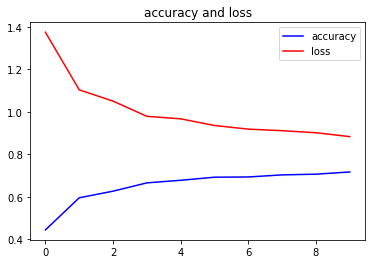

In [36]:
acc = V16.history['acc']
loss = V16.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

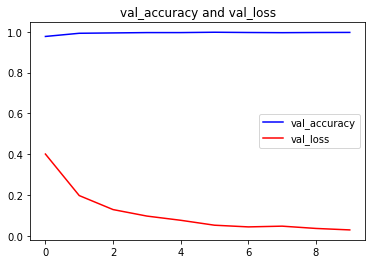

In [37]:
acc = V16.history['val_acc']
loss = V16.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='val_accuracy')
plt.plot(epochs, loss, 'r', label='val_loss')
plt.title('val_accuracy and val_loss')
plt.legend()
  
plt.show()

In [38]:
model_vggnet16.save("./workspace1/models/vggnet16_5class.h5")

In [39]:
#VGG19

In [40]:
start_time = start()
# 이미지 학습
V19 = model_vggnet19.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,validation_data = (X_val/255, y_val),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)
end1 = end(start_time)

Epoch 1/10
149/149 [==============================] - 210s 1s/step - loss: 1.4443 - acc: 0.4078 - val_loss: 0.5175 - val_acc: 0.9646
Epoch 2/10
149/149 [==============================] - 204s 1s/step - loss: 1.1783 - acc: 0.5521 - val_loss: 0.3023 - val_acc: 0.9899
Epoch 3/10
149/149 [==============================] - 201s 1s/step - loss: 1.1122 - acc: 0.5887 - val_loss: 0.2356 - val_acc: 0.9916
Epoch 4/10
149/149 [==============================] - 204s 1s/step - loss: 1.0699 - acc: 0.6135 - val_loss: 0.1564 - val_acc: 0.9916
Epoch 5/10
149/149 [==============================] - 206s 1s/step - loss: 1.0423 - acc: 0.6310 - val_loss: 0.1092 - val_acc: 0.9945
Epoch 6/10
149/149 [==============================] - 201s 1s/step - loss: 1.0195 - acc: 0.6461 - val_loss: 0.0913 - val_acc: 0.9945
Epoch 7/10
149/149 [==============================] - 202s 1s/step - loss: 1.0083 - acc: 0.6453 - val_loss: 0.0895 - val_acc: 0.9933
Epoch 8/10
149/149 [==============================] - 202s 1s/step - 

In [41]:
print('CNN Model time of : ', end1)

CNN Model time of :  2029.8114361763


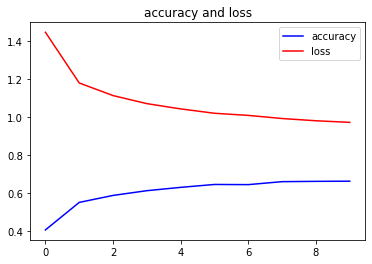

In [42]:
acc = V19.history['acc']
loss = V19.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

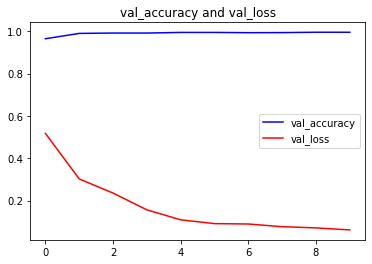

In [43]:
acc = V19.history['val_acc']
loss = V19.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='val_accuracy')
plt.plot(epochs, loss, 'r', label='val_loss')
plt.title('val_accuracy and val_loss')
plt.legend()
  
plt.show()

In [44]:
model_vggnet19.save("./workspace1/models/vggnet19_5class.h5")

In [45]:
#resnet50

In [46]:
start_time = start()
# 이미지 학습
R50 = model_resnet50.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,validation_data = (X_val/255, y_val),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)
end1 = end(start_time)

Epoch 1/10
149/149 [==============================] - 197s 1s/step - loss: 1.4195 - acc: 0.5358 - val_loss: 0.0390 - val_acc: 0.9954
Epoch 2/10
149/149 [==============================] - 190s 1s/step - loss: 1.0750 - acc: 0.6336 - val_loss: 0.0236 - val_acc: 0.9983
Epoch 3/10
149/149 [==============================] - 194s 1s/step - loss: 1.0302 - acc: 0.6464 - val_loss: 0.0116 - val_acc: 0.9992
Epoch 4/10
149/149 [==============================] - 194s 1s/step - loss: 0.9954 - acc: 0.6600 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 5/10
149/149 [==============================] - 191s 1s/step - loss: 0.9712 - acc: 0.6778 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 6/10
149/149 [==============================] - 193s 1s/step - loss: 0.9532 - acc: 0.6801 - val_loss: 0.0049 - val_acc: 0.9987
Epoch 7/10
149/149 [==============================] - 190s 1s/step - loss: 0.9545 - acc: 0.6807 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 8/10
149/149 [==============================] - 193s 1s/step - 

In [47]:
print('CNN Model time of : ', end1)

CNN Model time of :  1929.3638679981232


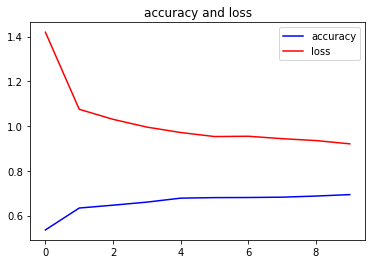

In [48]:
acc = R50.history['acc']
loss = R50.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

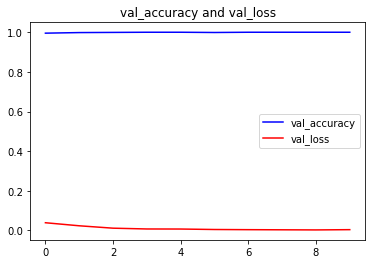

In [49]:
acc = R50.history['val_acc']
loss = R50.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='val_accuracy')
plt.plot(epochs, loss, 'r', label='val_loss')
plt.title('val_accuracy and val_loss')
plt.legend()
  
plt.show()

In [50]:
model_resnet50.save("./workspace1/models/resnet50_5class.h5")

In [51]:
#resnet101

In [52]:
start_time = start()
# 이미지 학습
R101 = model_resnet101.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,validation_data = (X_val/255, y_val),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)
end1 = end(start_time)

Epoch 1/10
149/149 [==============================] - 209s 1s/step - loss: 1.4758 - acc: 0.5285 - val_loss: 0.0732 - val_acc: 0.9848
Epoch 2/10
149/149 [==============================] - 196s 1s/step - loss: 1.1051 - acc: 0.6039 - val_loss: 0.0207 - val_acc: 0.9983
Epoch 3/10
149/149 [==============================] - 203s 1s/step - loss: 1.0668 - acc: 0.6249 - val_loss: 0.0280 - val_acc: 1.0000
Epoch 4/10
149/149 [==============================] - 198s 1s/step - loss: 1.0389 - acc: 0.6389 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 5/10
149/149 [==============================] - 198s 1s/step - loss: 1.0001 - acc: 0.6477 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 6/10
149/149 [==============================] - 202s 1s/step - loss: 0.9756 - acc: 0.6651 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 7/10
149/149 [==============================] - 199s 1s/step - loss: 0.9672 - acc: 0.6681 - val_loss: 0.0052 - val_acc: 0.9996
Epoch 8/10
149/149 [==============================] - 198s 1s/step - 

In [53]:
print('CNN Model time of : ', end1)

CNN Model time of :  2002.7147495746613


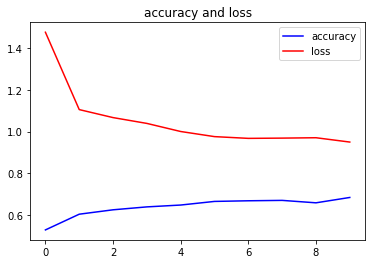

In [54]:
acc = R101.history['acc']
loss = R101.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

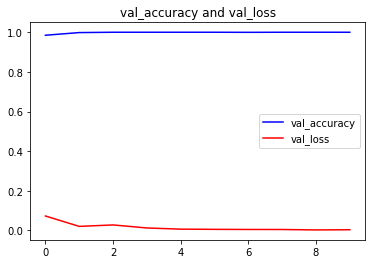

In [55]:
acc = R101.history['val_acc']
loss = R101.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='val_accuracy')
plt.plot(epochs, loss, 'r', label='val_loss')
plt.title('val_accuracy and val_loss')
plt.legend()
  
plt.show()

In [56]:
model_resnet101.save("./workspace1/models/resnet101_5class.h5")

In [57]:
#resnet152

In [58]:
start_time = start()
# 이미지 학습
R152 = model_resnet152.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,validation_data = (X_val/255, y_val),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)
end1 = end(start_time)

Epoch 1/10
149/149 [==============================] - 212s 1s/step - loss: 1.4775 - acc: 0.5419 - val_loss: 0.0278 - val_acc: 0.9975
Epoch 2/10
149/149 [==============================] - 206s 1s/step - loss: 1.0630 - acc: 0.6303 - val_loss: 0.0196 - val_acc: 0.9975
Epoch 3/10
149/149 [==============================] - 209s 1s/step - loss: 1.0158 - acc: 0.6585 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 4/10
149/149 [==============================] - 209s 1s/step - loss: 0.9768 - acc: 0.6799 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 5/10
149/149 [==============================] - 210s 1s/step - loss: 0.9685 - acc: 0.6822 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 6/10
149/149 [==============================] - 207s 1s/step - loss: 0.9607 - acc: 0.6824 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 7/10
149/149 [==============================] - 205s 1s/step - loss: 0.9411 - acc: 0.6943 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 8/10
149/149 [==============================] - 205s 1s/step - 

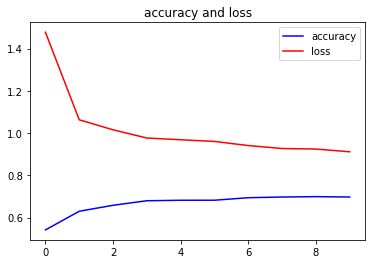

In [59]:
acc = R152.history['acc']
loss = R152.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

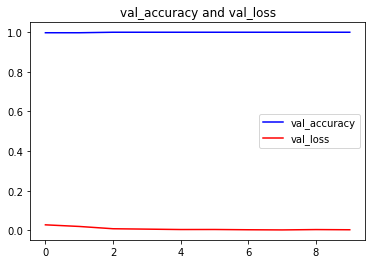

In [60]:
acc = R152.history['val_acc']
loss = R152.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='val_accuracy')
plt.plot(epochs, loss, 'r', label='val_loss')
plt.title('val_accuracy and val_loss')
plt.legend()
  
plt.show()

In [61]:
model_resnet152.save("./workspace1/models/resnet152_5class.h5")